In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tarfile
import os
import pandas as pd
import string
import numpy as np
import matplotlib.pyplot as plt
punctuations= string.punctuation
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
stopword_list = stopwords.words("english")
from nltk.stem.wordnet import WordNetLemmatizer
lem = WordNetLemmatizer()
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,Tfidf1ransformer
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix,f1_score,precision_recall_fscore_support,log_loss
from sklearn.linear_model import Lasso, SGDClassifier,LogisticRegression as LR
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.datasets import make_blobs
from sklearn.neural_network import MLPClassifier
from tqdm import tqdm
from sklearn.svm import SVC
import seaborn as sns
import pylab as pl
import tensorflow as tf
import re
import shutil
import string
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In this assignment you will work with text classification in Keras. The colab notebook is available here.  GOOGLE as much as possible. Lots of deep learning discussions happen on stack overflow.

https://www.tensorflow.org/tutorials/keras/text_classification (Links to an external site.)

You need to get familiar with the code. Once you are familiar with Keras code, you can start to experiment with different hyperparameters. How does the performance (F-score) of the models vary with different settings?

Size of embedding layer by varying the size for a range of numbers greater than 2.
Dropout size: Try three values.
Add an extra layer of neurons with Dense (also known as feed forward neural network as mentioned in Goldberg's chapter). Can you experiment with three different non-linearities? 
Batch size: Try two values
Training algorithm. Try two algorithms. https://cs231n.github.io/neural-networks-3/

**Feed Forward Neural Network**

In [ ]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset = tf.keras.utils.get_file("aclImdb_v1", url, untar=True, cache_dir='.',cache_subdir='')
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
train_dir = os.path.join(dataset_dir, 'train')
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)
batch_size = 32
seed = 42
raw_train_ds = tf.keras.utils.text_dataset_from_directory('aclImdb/train', batch_size=batch_size, validation_split=0.2, subset='training', seed=seed)
raw_val_ds = tf.keras.utils.text_dataset_from_directory('aclImdb/train', batch_size=batch_size, validation_split=0.2, subset='validation', seed=seed)
raw_test_ds = tf.keras.utils.text_dataset_from_directory('aclImdb/test', batch_size=batch_size)

84140032/84125825 [==============================] - 3s 0us/step
Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [ ]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,'[%s]' % re.escape(string.punctuation),'')
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

max_features = 10000
sequence_length = 250
vectorize_layer = layers.TextVectorization(standardize=custom_standardization,max_tokens=max_features,output_mode='int',output_sequence_length=sequence_length)
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
import keras.backend as K
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping,TensorBoard
embedding_dim = 16
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1,activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(1,activation='tanh'),
  layers.Dropout(0.2),
  layers.Dense(1,activation='sigmoid')])

model.summary()

modal = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1,activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(1,activation='tanh'),
  layers.Dropout(0.2),
  layers.Dense(1,activation='sigmoid')])

modal.summary()

def f1_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
model.compile(loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=[f1_metric])
epochs = 10
callbacks=[ReduceLROnPlateau()]

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, None, 16)          160016    
_________________________________________________________________
dropout_49 (Dropout)         (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d_13  (None, 16)                0         
_________________________________________________________________
dropout_50 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 17        
_________________________________________________________________
dropout_51 (Dropout)         (None, 1)                 0         
_________________________________________________________________
dense_36 (Dense)             (None, 1)               

Model 1

In [ ]:
history = model.fit(train_ds,validation_data=val_ds,epochs=epochs,callbacks=callbacks,batch_size=32)

Epoch 1/10
625/625 [==============================] - 13s 16ms/step - loss: 0.6877 - f1_metric: 0.2020 - val_loss: 0.6555 - val_f1_metric: 0.7227
Epoch 2/10
625/625 [==============================] - 4s 6ms/step - loss: 0.5904 - f1_metric: 0.7342 - val_loss: 0.4890 - val_f1_metric: 0.8527
Epoch 3/10
625/625 [==============================] - 4s 6ms/step - loss: 0.5217 - f1_metric: 0.7511 - val_loss: 0.4219 - val_f1_metric: 0.8650
Epoch 4/10
625/625 [==============================] - 4s 6ms/step - loss: 0.4945 - f1_metric: 0.7339 - val_loss: 0.4011 - val_f1_metric: 0.8727
Epoch 5/10
625/625 [==============================] - 4s 6ms/step - loss: 0.4789 - f1_metric: 0.7508 - val_loss: 0.3867 - val_f1_metric: 0.8711
Epoch 6/10
625/625 [==============================] - 4s 6ms/step - loss: 0.4636 - f1_metric: 0.7585 - val_loss: 0.3755 - val_f1_metric: 0.8757
Epoch 7/10
625/625 [==============================] - 4s 6ms/step - loss: 0.4508 - f1_metric: 0.7663 - val_loss: 0.3662 - val_f1_metri

Model 2

In [ ]:
modal.compile(loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=[f1_metric])
history1 = modal.fit(train_ds,validation_data=val_ds,epochs=epochs,callbacks=callbacks,batch_size=64)
loss, accuracy = modal.evaluate(test_ds)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

Epoch 1/10
625/625 [==============================] - 5s 6ms/step - loss: 0.6746 - f1_metric: 0.4195 - val_loss: 0.6128 - val_f1_metric: 0.8006
Epoch 2/10
625/625 [==============================] - 4s 6ms/step - loss: 0.5604 - f1_metric: 0.7494 - val_loss: 0.4586 - val_f1_metric: 0.8626
Epoch 3/10
625/625 [==============================] - 4s 6ms/step - loss: 0.5001 - f1_metric: 0.7785 - val_loss: 0.4040 - val_f1_metric: 0.8739
Epoch 4/10
625/625 [==============================] - 4s 6ms/step - loss: 0.4836 - f1_metric: 0.7789 - val_loss: 0.3852 - val_f1_metric: 0.8752
Epoch 5/10
625/625 [==============================] - 4s 6ms/step - loss: 0.4616 - f1_metric: 0.7579 - val_loss: 0.3758 - val_f1_metric: 0.8752
Epoch 6/10
625/625 [==============================] - 4s 6ms/step - loss: 0.4600 - f1_metric: 0.7548 - val_loss: 0.3653 - val_f1_metric: 0.8766
Epoch 7/10
625/625 [==============================] - 4s 6ms/step - loss: 0.4420 - f1_metric: 0.7691 - val_loss: 0.3657 - val_f1_metric:

Model 1 Performace on Test Dataset

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 8s 10ms/step - loss: 0.3762 - f1_metric: 0.8653
Loss:  0.37620070576667786
Accuracy:  0.8653008937835693


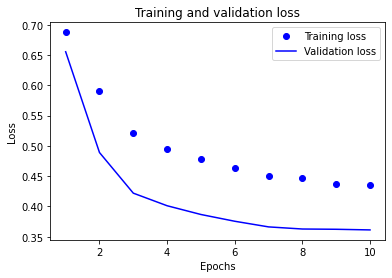

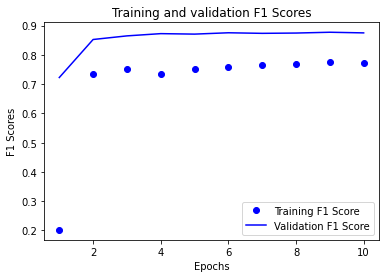

In [ ]:
acc = history.history['f1_metric']
val_acc = history.history['val_f1_metric']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, sorted(loss,reverse=True), 'bo', label='Training loss')
plt.plot(epochs, sorted(val_loss,reverse=True), 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.plot(epochs, acc, 'bo', label='Training F1 Score')
plt.plot(epochs, val_acc, 'b', label='Validation F1 Score')
plt.title('Training and validation F1 Scores')
plt.xlabel('Epochs')
plt.ylabel('F1 Scores')
plt.legend(loc='lower right')
plt.show()

In [ ]:
export_model = tf.keras.Sequential([vectorize_layer,model,layers.Activation('sigmoid')])
export_model.compile(loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=[f1_metric])
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 9s 11ms/step - loss: 0.7241 - f1_metric: 0.6625
0.6625464558601379


In [ ]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]
export_model.predict(examples)

array([[0.6831099],
       [0.5554961],
       [0.5299033]], dtype=float32)

Word embeddings: Can you look at a word of your choice and identify the top 10 words that are most similar to your choice word. How did you do that? Document your process.

I have trained Custom Word2Vec Embeddings only on our entire text given, calling in the form of Dataframes

In [ ]:
path = '/content/drive/My Drive/'
df = pd.read_csv(path + 'trainffn.csv')
df1 = pd.read_csv(path + 'testffn.csv')
x=df['text'].append(df1['text'])

In [ ]:
from gensim.models import Word2Vec
# define training data
sentences = [['this', 'is', 'the', 'first', 'sentence', 'for', 'word2vec'],
			['this', 'is', 'the', 'second', 'sentence'],
			['yet', 'another', 'sentence'],
			['one', 'more', 'sentence'],
			['and', 'the', 'final', 'sentence']]
# train model
model = Word2Vec([i.split() for i in x], min_count=1)
words = list(model.wv.vocab)
model.save('model.bin')
new_model = Word2Vec.load('model.bin')
new_model.most_similar(positive=['make'], topn=10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).


[('create', 0.5375388264656067),
 ('sentencelong', 0.5084735751152039),
 ('actually', 0.4972057342529297),
 ('maker', 0.49004247784614563),
 ('downturned', 0.48531222343444824),
 ('common', 0.4819379448890686),
 ('throatclenching', 0.4816790521144867),
 ('still', 0.48053935170173645),
 ('errupted', 0.47936275601387024),
 ('neargenius', 0.4679349660873413)]

Comparison with Logistic Regression model: Train a logistic regression model with sklearn based on the TF-IDF vectorizer and compare the model's performance with a model trained using count vectorizer. Can you compare the performance of the logistic regression models with the deep learning models that you trained above? Make sure that you use the same split for training and testing both Keras and sklearn models. Note that sklearn data split function can give a different train-test split than the Keras function: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text_dataset_from_directory

**Logistic Regression with Count Vectorizer**

train accuracy: 0.7685
The accuracy of the model is : 50.0 %
Confusion Matrix:
 [[42 58]
 [42 58]]
Precision =  0.5 
Recall =  0.5 
F-Score =  0.4968


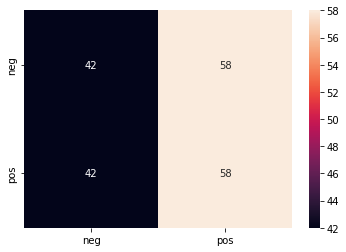

In [ ]:
def confusion_matrixs(y, yp):
  #k = sorted(y.unique())
  k = sorted(list(set(y)))
  df = pd.DataFrame(index=k, columns=k)
  df.fillna(0, inplace=True)
  for i, j in zip(y, yp):
    df.loc[i, j] += 1
  sns.heatmap(df, annot=True)
  plt.plot()
def get_feature_list(x,y,pca=0):
  count_transformer1 = CountVectorizer()
  x1= count_transformer1.fit_transform(x)
  x1 = x1.toarray()
  if pca !=0:
    pcas = PCA(pca).fit(x1)
    x1 = pcas.transform(x1)
  train_x,train_y = x1,y
  return train_x,train_y
x=df['text']
y=df['label']
xt=df1['text']
yt=df1['label']
train_x,train_y= get_feature_list(x,y,pca=100)
test_x,test_y= get_feature_list(xt,yt,pca=100)

X_train,y_train,X_test,y_test=train_x,train_y,test_x,test_y
sgdl = SGDClassifier(eta0=0.0001, alpha=0.0001, loss='log',random_state=15, penalty='elasticnet', tol=1e-3,learning_rate='optimal')
sgdl.fit(X_train, y_train)
print(f'train accuracy: {sgdl.score(X_train, y_train)}')
accuracy = accuracy_score(y_test, sgdl.predict(X_test))
conf_mat = confusion_matrix(y_test,sgdl.predict(X_test))
c=np.array([[i] for i in np.append(np.array([[i] for i in sgdl.coef_[0]]),[0])])
print("The accuracy of the model is :", round(accuracy,3)*100,"%")
print("Confusion Matrix:\n",conf_mat)
precision, recall, fscore, support = precision_recall_fscore_support(y_test,sgdl.predict(X_test), average='weighted')
print('Precision = ',round(precision,4),'\nRecall = ', round(recall,4), '\nF-Score = ',round(fscore,4))
confusion_matrixs(y_test, sgdl.predict(X_test))

**Logistic Regression with Tf-Idf Vectorizer**

train accuracy: 0.845
The accuracy of the model is : 53.0 %
Confusion Matrix:
 [[46 54]
 [40 60]]
Precision =  0.5306 
Recall =  0.53 
F-Score =  0.5277


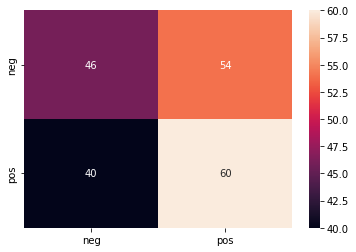

In [ ]:
def get_feature_list(x,y,pca=0):
  tfidf_transformer1 = TfidfVectorizer()
  x1= tfidf_transformer1.fit_transform(x)
  x1 = x1.toarray()
  if pca !=0:
    pcas = PCA(pca).fit(x1)
    x1 = pcas.transform(x1)
  train_x,train_y = x1,y
  return train_x,train_y
x=df['text']
y=df['label']
xt=df1['text']
yt=df1['label']
train_x,train_y= get_feature_list(x,y,pca=100)
test_x,test_y= get_feature_list(xt,yt,pca=100)
X_train,y_train,X_test,y_test=train_x,train_y,test_x,test_y
sgdl = SGDClassifier(eta0=0.0001, alpha=0.0001, loss='log',random_state=15, penalty='elasticnet', tol=1e-3,learning_rate='optimal')
sgdl.fit(X_train, y_train)
print(f'train accuracy: {sgdl.score(X_train, y_train)}')
accuracy = accuracy_score(y_test, sgdl.predict(X_test))
conf_mat = confusion_matrix(y_test,sgdl.predict(X_test))
c=np.array([[i] for i in np.append(np.array([[i] for i in sgdl.coef_[0]]),[0])])
print("The accuracy of the model is :", round(accuracy,3)*100,"%")
print("Confusion Matrix:\n",conf_mat)
precision, recall, fscore, support = precision_recall_fscore_support(y_test,sgdl.predict(X_test), average='weighted')
print('Precision = ',round(precision,4),'\nRecall = ', round(recall,4), '\nF-Score = ',round(fscore,4))
confusion_matrixs(y_test, sgdl.predict(X_test))

**Comparision of Model Performances on Testing Dataset Nueral Network Feed forward and Logistic Regression **

Feed Forward Neural Networks is 86.5%

Logistic Regression with Count Vectorisation is 50%

Logistic Regression with Tf-Idf Vectorisation is 53%
